## Timeseries Data

Go over using Time Series MongoDB collections by scraping stock market data over the internet

##### Install Dependencies In Terminal (if you do not already have it)
```bash
pip install --user yfinance
pip install --user matplotlib
```

In [6]:
from pymongo import MongoClient

import pandas
import yfinance as yf
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

### Intro to yfinance

In [7]:
tickers = ["AMZN", "GOOGL"]
data = yf.download(tickers=tickers, period="1y", interval="1d")

C:\Users\yfess\AppData\Local\Temp\ipykernel_11360\883567138.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers=tickers, period="1y", interval="1d")
[*********************100%***********************]  2 of 2 completed


In [8]:
print(type(data))
data[0:3]

<class 'pandas.core.frame.DataFrame'>


Price            Close                    High                     Low  \
Ticker            AMZN       GOOGL        AMZN       GOOGL        AMZN   
Date                                                                     
2024-07-18  183.750000  176.833405  189.679993  181.620214  181.449997   
2024-07-19  183.130005  176.803558  184.929993  179.420870  180.110001   
2024-07-22  182.550003  180.794205  185.059998  181.819238  182.479996   

Price                         Open                Volume            
Ticker           GOOGL        AMZN       GOOGL      AMZN     GOOGL  
Date                                                                
2024-07-18  175.619285  189.589996  181.052955  51043600  25315700  
2024-07-19  176.276115  181.139999  178.017678  43081800  18881900  
2024-07-22  179.361144  185.000000  179.719409  39931900  24100300

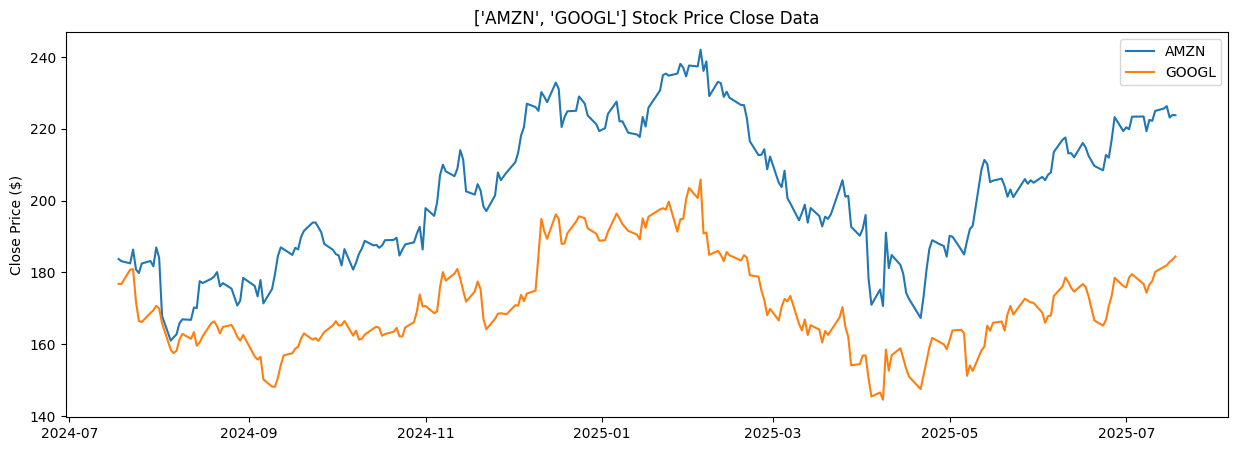

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
for ticker in tickers:
    plt.plot(data.index, data[("Close", ticker)], label=ticker)
plt.title(str(tickers) + " Stock Price Close Data")
plt.ylabel("Close Price ($)")
plt.legend()
plt.show()

### Converting yfinance dataframe to dict format for insertion

##### Swap the columns so the ticker names are the highest level column

In [10]:
data.columns = data.columns.swaplevel(0,1)
data[0:3]

Ticker,AMZN,GOOGL,AMZN,GOOGL,AMZN,GOOGL,AMZN,GOOGL,AMZN,GOOGL
Price,Close,Close,High,High,Low,Low,Open,Open,Volume,Volume
Date,,,,,,,,,,
2024-07-18,183.750000,176.833405,189.679993,181.620214,181.449997,175.619285,189.589996,181.052955,51043600,25315700
2024-07-19,183.130005,176.803558,184.929993,179.420870,180.110001,176.276115,181.139999,178.017678,43081800,18881900
2024-07-22,182.550003,180.794205,185.059998,181.819238,182.479996,179.361144,185.000000,179.719409,39931900,24100300


In [11]:
data["AMZN"][0:3]

Price,Close,High,Low,Open,Volume
Date,,,,,
2024-07-18,183.750000,189.679993,181.449997,189.589996,51043600
2024-07-19,183.130005,184.929993,180.110001,181.139999,43081800
2024-07-22,182.550003,185.059998,182.479996,185.000000,39931900


##### Create an attribute an each entry that has the name of the ticker

In [12]:
for ticker in tickers:
    data.loc[: , (ticker, "Ticker")] = ticker

In [13]:
data["GOOGL"][0:3]

Price,Close,High,Low,Open,Volume,Ticker
Date,,,,,,
2024-07-18,176.833405,181.620214,175.619285,181.052955,25315700,GOOGL
2024-07-19,176.803558,179.420870,176.276115,178.017678,18881900,GOOGL
2024-07-22,180.794205,181.819238,179.361144,179.719409,24100300,GOOGL


##### Set date index to a column 

In [14]:
data["AMZN"].reset_index(level=0)[0:3]

Price,Date,Close,High,Low,Open,Volume,Ticker
0,2024-07-18,183.750000,189.679993,181.449997,189.589996,51043600,AMZN
1,2024-07-19,183.130005,184.929993,180.110001,181.139999,43081800,AMZN
2,2024-07-22,182.550003,185.059998,182.479996,185.000000,39931900,AMZN


##### Convert the dataframe to an array of dictionaries 

In [15]:
data["AMZN"].reset_index(level=0).to_dict('records')[0:2]

[{'Date': Timestamp('2024-07-18 00:00:00'),
  'Close': 183.75,
  'High': 189.67999267578125,
  'Low': 181.4499969482422,
  'Open': 189.58999633789062,
  'Volume': 51043600,
  'Ticker': 'AMZN'},
 {'Date': Timestamp('2024-07-19 00:00:00'),
  'Close': 183.1300048828125,
  'High': 184.92999267578125,
  'Low': 180.11000061035156,
  'Open': 181.13999938964844,
  'Volume': 43081800,
  'Ticker': 'AMZN'}]

### Connect To MongoDB instance

In [16]:
mongodb_uri = "mongodb://localhost:27017/"
db_name = "advanced_features"

In [17]:
client = MongoClient(mongodb_uri)
db = client[db_name]

### Creating  A Time-Series Collection

You could also use the compass app or mongoshell

In [18]:
try:
        db.create_collection("historical_stock_data", timeseries= {
        "timeField": "Date",
        "metaField": "Ticker",
        "granularity": "hours"
        }, expireAfterSeconds= 60 * 60 * 24 * 365 ### 1 year 
        )
except Exception as e:
        print(f"Collection creation failed: {e}")

Collection creation failed: collection historical_stock_data already exists


### Inserting The Time-Series Stock Data

##### Download the data

In [19]:
tickers = ["AMZN", "FB", "GOOGL", "MSFT", "UDMY"]
data = yf.download(tickers=tickers, period="2y", interval="1d")

C:\Users\yfess\AppData\Local\Temp\ipykernel_11360\2770221848.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers=tickers, period="2y", interval="1d")
[*********************100%***********************]  5 of 5 completed


In [27]:
data.head(1)

Ticker,AMZN,FB,GOOGL,MSFT,UDMY,AMZN,FB,GOOGL,MSFT,UDMY,...,AMZN,FB,GOOGL,MSFT,UDMY,AMZN,FB,GOOGL,MSFT,UDMY
Price,Close,Close,Close,Close,Close,High,High,High,High,High,...,Volume,Volume,Volume,Volume,Volume,Ticker,Ticker,Ticker,Ticker,Ticker
Date,,,,,,,,,,,,,,,,,,,,,
2023-07-18,132.830002,NaN,123.022186,353.985657,11.52,133.860001,NaN,123.9367,361.164044,11.665,...,54882900,NaN,26193600,64738600,428500,AMZN,FB,GOOGL,MSFT,UDMY


##### Process dataframe into list of dictionaries

In [20]:
stock_data_to_insert = []

data.columns = data.columns.swaplevel(0,1)

for ticker in tickers:
    data.loc[: , (ticker, "Ticker")] = ticker
    stock_data_to_insert.extend(data[ticker].reset_index(level=0).to_dict('records'))

In [21]:
stock_data_to_insert[0:2]

[{'Date': Timestamp('2023-07-18 00:00:00'),
  'Close': 132.8300018310547,
  'High': 133.86000061035156,
  'Low': 131.35000610351562,
  'Open': 132.7100067138672,
  'Volume': 54882900,
  'Ticker': 'AMZN'},
 {'Date': Timestamp('2023-07-19 00:00:00'),
  'Close': 135.36000061035156,
  'High': 135.99000549316406,
  'Low': 132.52999877929688,
  'Open': 133.38999938964844,
  'Volume': 54531000,
  'Ticker': 'AMZN'}]

##### Call insert_many() on time series collection

In [22]:
db.historical_stock_data.insert_many(stock_data_to_insert)

InsertManyResult([ObjectId('687a5db2d20ee8a0fe576e7c'), ObjectId('687a5db2d20ee8a0fe576e7d'), ObjectId('687a5db2d20ee8a0fe576e7e'), ObjectId('687a5db2d20ee8a0fe576e7f'), ObjectId('687a5db2d20ee8a0fe576e80'), ObjectId('687a5db2d20ee8a0fe576e81'), ObjectId('687a5db2d20ee8a0fe576e82'), ObjectId('687a5db2d20ee8a0fe576e83'), ObjectId('687a5db2d20ee8a0fe576e84'), ObjectId('687a5db2d20ee8a0fe576e85'), ObjectId('687a5db2d20ee8a0fe576e86'), ObjectId('687a5db2d20ee8a0fe576e87'), ObjectId('687a5db2d20ee8a0fe576e88'), ObjectId('687a5db2d20ee8a0fe576e89'), ObjectId('687a5db2d20ee8a0fe576e8a'), ObjectId('687a5db2d20ee8a0fe576e8b'), ObjectId('687a5db2d20ee8a0fe576e8c'), ObjectId('687a5db2d20ee8a0fe576e8d'), ObjectId('687a5db2d20ee8a0fe576e8e'), ObjectId('687a5db2d20ee8a0fe576e8f'), ObjectId('687a5db2d20ee8a0fe576e90'), ObjectId('687a5db2d20ee8a0fe576e91'), ObjectId('687a5db2d20ee8a0fe576e92'), ObjectId('687a5db2d20ee8a0fe576e93'), ObjectId('687a5db2d20ee8a0fe576e94'), ObjectId('687a5db2d20ee8a0fe576e

### Retrieving Time-Series Data

In [23]:
gt_date = datetime.now() - relativedelta(months=6)
gt_date

datetime.datetime(2025, 1, 18, 16, 44, 2, 267204)

In [24]:
ts_cursor = db.historical_stock_data.find({"Ticker": "FB", "Date": {"$gte": gt_date} })

fb_price_data = []

for entry in ts_cursor:
    fb_price_data.append(entry)
    
print(fb_price_data[0:2])

[{'Date': datetime.datetime(2025, 1, 21, 0, 0), 'Ticker': 'FB', 'Close': nan, '_id': ObjectId('687a5abbf42f735987f2bdb2'), 'High': nan, 'Open': nan, 'Low': nan, 'Volume': nan}, {'Date': datetime.datetime(2025, 1, 22, 0, 0), 'Ticker': 'FB', 'Close': nan, '_id': ObjectId('687a5abbf42f735987f2bdb3'), 'High': nan, 'Open': nan, 'Low': nan, 'Volume': nan}]


In [25]:
read_in_data = pandas.DataFrame(fb_price_data)
read_in_data = read_in_data.set_index("Date")
read_in_data = read_in_data.drop("_id", axis=1)

read_in_data

,Ticker,Close,High,Open,Low,Volume
Date,,,,,,
2025-01-21,FB,NaN,NaN,NaN,NaN,NaN
2025-01-22,FB,NaN,NaN,NaN,NaN,NaN
2025-01-23,FB,NaN,NaN,NaN,NaN,NaN
2025-01-24,FB,NaN,NaN,NaN,NaN,NaN
2025-01-27,FB,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2025-07-17,FB,40.5130,40.528999,40.444,40.444000,2000.0
2025-07-18,FB,40.5126,40.529400,40.444,40.444000,97.0
2025-07-16,FB,40.4580,40.500000,40.480,40.389999,97600.0
